In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------- Model ---------------------------------- #
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GaussianNoise
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

import os
os.chdir("../")
from Sources.tools import *

# Data Prepocessing

In [2]:
df = get_technical_df()
df = compute_indicators(df)

In [3]:
df

,open,high,low,close,volume,SMA_20,EMA_20,Bollinger_Mid,Bollinger_Std,Bollinger_Upper,Bollinger_Lower,RSI
0,4178.6201,4210.8501,4144.0298,4148.4302,2264230000,4182.642015,4191.007524,4182.642015,53.173207,4288.988428,4076.295602,43.809349
1,4162.2002,4189.0898,4094.7300,4188.5898,2006450000,4180.559495,4190.777264,4180.559495,52.013895,4284.587284,4076.531706,51.788213
2,4201.9399,4229.1499,4174.2300,4229.1499,2153520000,4183.968990,4194.431801,4183.968990,52.889086,4289.747163,4078.190817,55.646620
3,4202.4302,4248.8398,4198.7402,4221.2002,2212960000,4189.487495,4196.981172,4189.487495,50.562958,4290.613411,4088.361579,56.913801
4,4229.6201,4258.0000,4220.1699,4256.1802,2036590000,4194.296505,4202.619175,4194.296505,52.159429,4298.615363,4089.977647,65.896670
...,...,...,...,...,...,...,...,...,...,...,...,...
1990,10911.0400,11007.0898,10830.9004,10985.4502,3544680000,11519.855410,11386.909636,11519.855410,341.364356,12202.584122,10837.126698,30.054731
1991,10944.2998,10957.4404,10807.6104,10822.5098,3827290000,11481.593400,11333.157271,11481.593400,374.620119,12230.833638,10732.353162,31.206913
1992,10807.1201,10898.6396,10671.1904,10679.3398,3842970000,11440.387880,11270.888940,11440.387880,415.213304,12270.814487,10609.961273,29.806939
1993,10800.7998,10981.0596,10776.6201,10951.0498,4154100000,11386.437390,11240.428070,11386.437390,404.524775,12195.486939,10577.387841,34.089112


In [4]:
# Normalization and split
train_df, test_df, val_df, scaler = get_scaled_split(df)

Train size: 1396
Validation size: 199
Test size: 400


In [5]:
nb_train = train_df.shape[0]
nb_val = val_df.shape[0]
nb_test = test_df.shape[0]

In [6]:
data = np.vstack((train_df,val_df,test_df))

In [7]:
# Creating input sequences for training
def create_sequences(data, seq_length=60, horizon=365):
    X = []
    y = []
    for i in range(seq_length, len(data) - horizon):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i + horizon, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(data)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [8]:
x1 = nb_train - 59
x2 = x1 + nb_val

X_train, y_train = X[:x1], y[:x1]
X_val, y_val = X[x1:x2], y[x1:x2]
X_test, y_test = X[x2:], y[x2:]

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(X_train.shape[0] + X_val.shape[0] + X_test.shape[0])

(1337, 60, 1)
(199, 60, 1)
(34, 60, 1)
1570


In [10]:
X.shape

(1570, 60, 1)

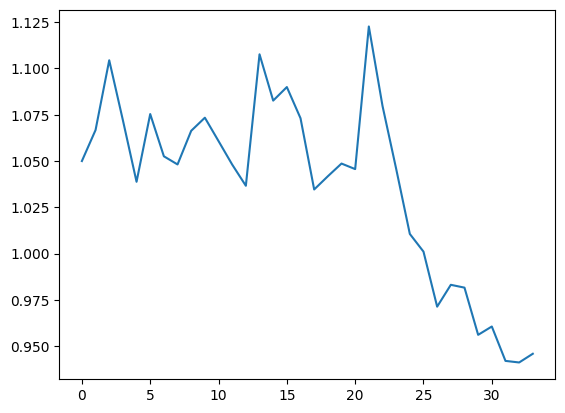

In [11]:
plt.plot(y_test)

# LSTM

In [12]:
# Création du modèle
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)  # 1 sortie par pas de temps à prédire
])


# Optimizer
model.compile(optimizer="adam", loss='mse', metrics=['mse'])

# Affichage du modèle
model.summary()

c:\Users\planc\anaconda3\envs\env_dl_project\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Entraînement
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.2623 - mse: 0.2623 - val_loss: 1.0508 - val_mse: 1.0508
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0399 - mse: 0.0399 - val_loss: 1.1907 - val_mse: 1.1907
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0403 - mse: 0.0403 - val_loss: 1.4533 - val_mse: 1.4533
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0409 - mse: 0.0409 - val_loss: 0.9002 - val_mse: 0.9002
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0339 - mse: 0.0339 - val_loss: 0.6235 - val_mse: 0.6235
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0303 - mse: 0.0303 - val_loss: 0.2742 - val_mse: 0.2742
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0261 - mse: 0.0261 - val_loss: 0.3028 - val_mse: 0.3028
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0242 - mse: 0.0242 - val_loss: 0.0862 - val_mse: 0.0862
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - lo

# Results

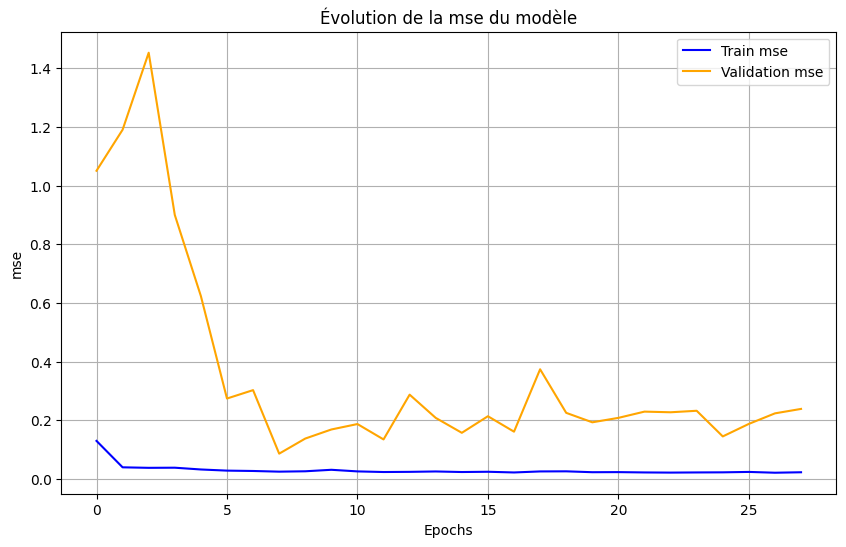

In [14]:
plot_training_curves(history, "mse")

## Train

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
----- Résultats des métriques -----
RMSE : 0.13967102650507707
MAE : 0.10662762992265493
R² : 0.9046239211683735
NMAE : 0.15500676102729666
Model Accuracy: 31.19%
MAPE: 21.89%
SMAPE : 20.20%


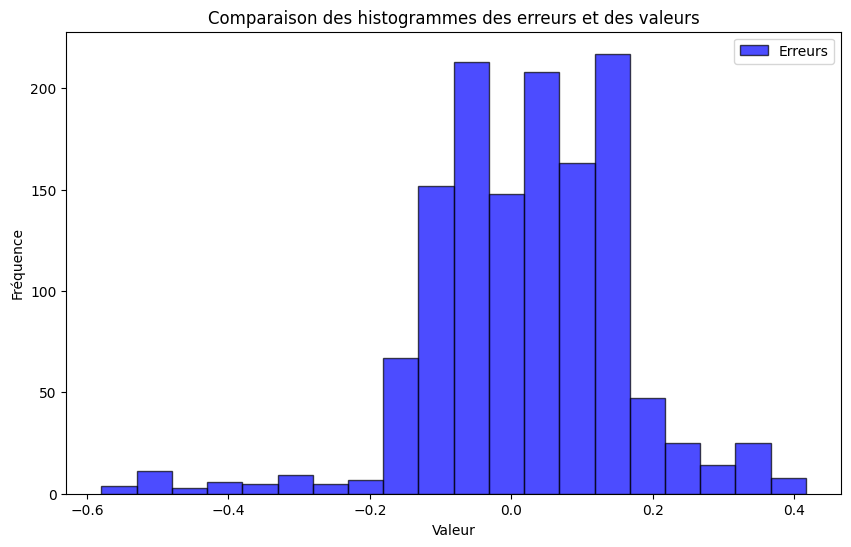

In [15]:
y_pred_train = model.predict(X_train)

y_pred_train_flat = y_pred_train.flatten()
y_train_flat = y_train.flatten()

get_performance_metrics(y_train_flat, y_pred_train_flat)
plot_errors_hist(y_train_flat, y_pred_train_flat)

## Test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
----- Résultats des métriques -----
RMSE : 0.4182894897218758
MAE : 0.41495745370517584
R² : -70.41157841236256
NMAE : 0.4001456015516202
Model Accuracy: 0.00%
MAPE: 40.36%
SMAPE : 33.43%


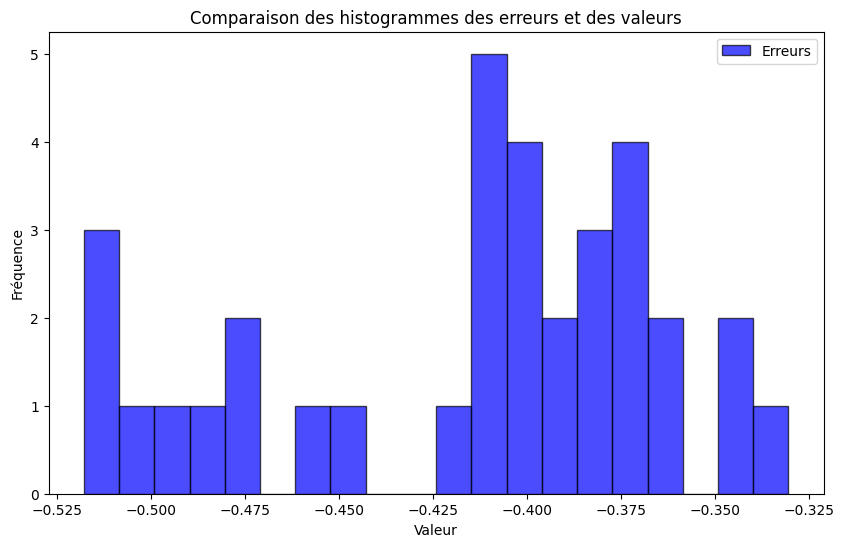

In [16]:
y_pred_test = model.predict(X_test)

y_pred_test_flat = y_pred_test.flatten()
y_test_flat = y_test.flatten()

get_performance_metrics(y_test_flat, y_pred_test_flat)
plot_errors_hist(y_test_flat, y_pred_test_flat)

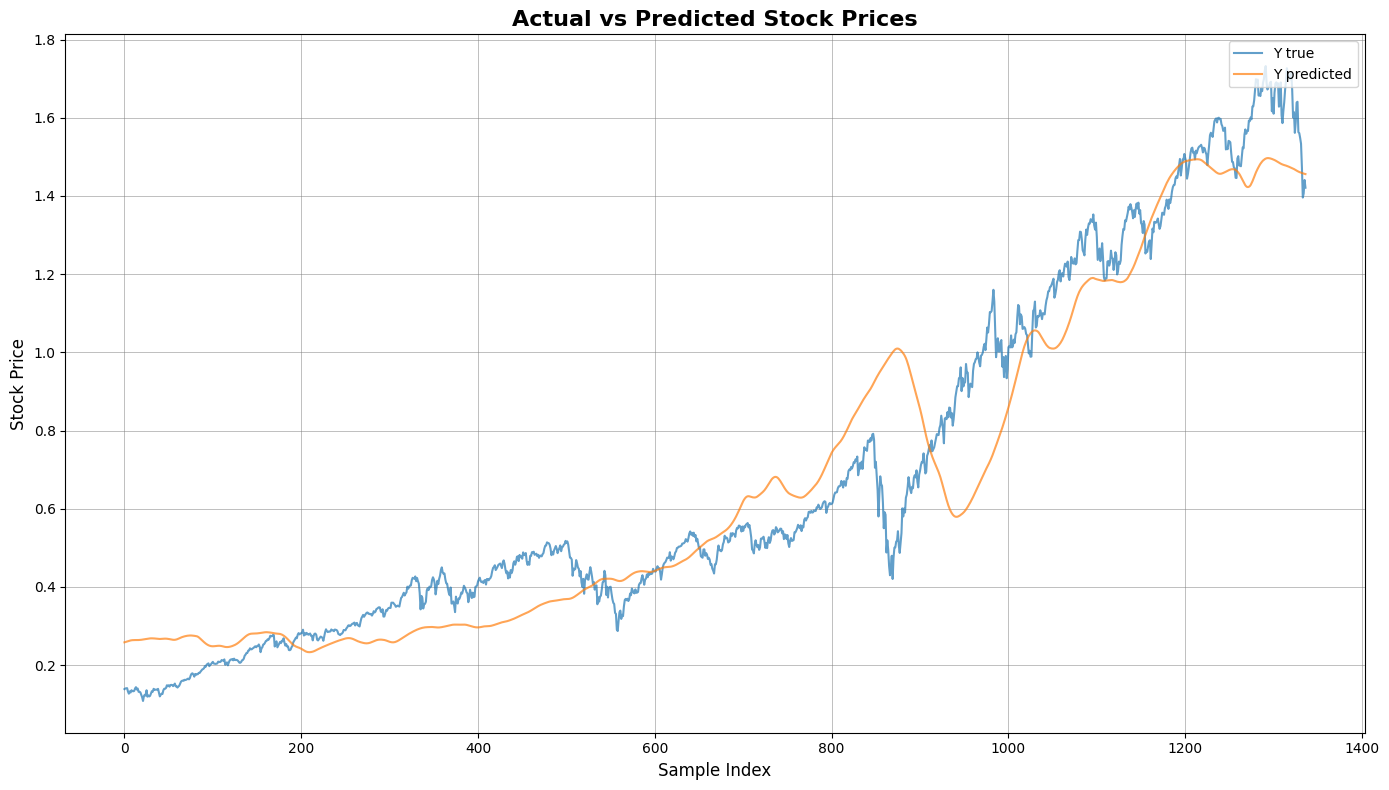

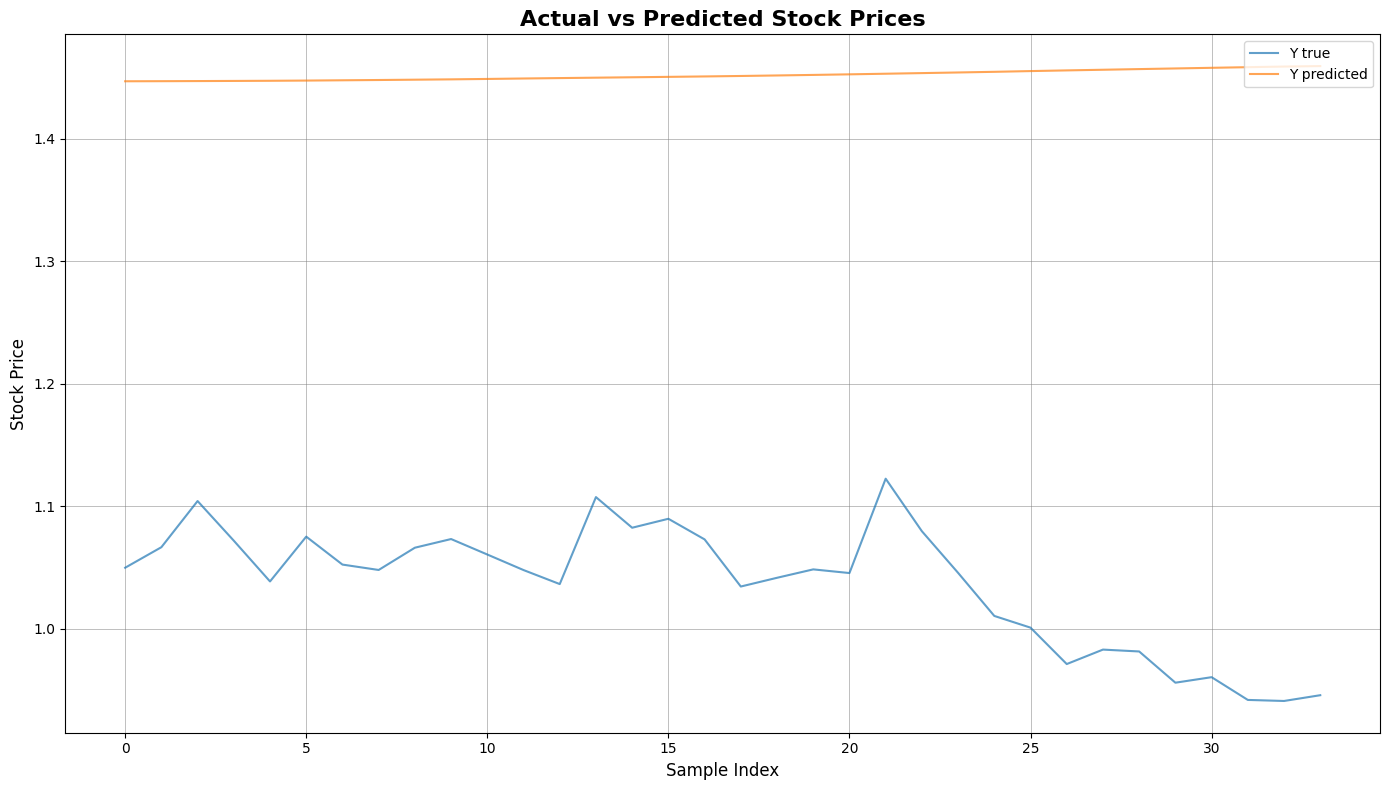

In [17]:
def plot_predictions(y_test, y_pred):
    """
    Affiche les vraies valeurs et les prédictions des prix d'actions en respectant la temporalité.
    
    Paramètres :
    - y_test : np.array de forme (N, 3), valeurs réelles
    - y_pred : np.array de forme (N, 3), valeurs prédites
    """
    plt.figure(figsize=(14, 8))

    plt.plot(y_test, label="Y true", alpha=0.7, linewidth=1.5)
    plt.plot(y_pred, label="Y predicted", alpha=0.7, linewidth=1.5)

    # Ajout des détails
    plt.grid(color='gray', linewidth=0.5, alpha=0.7)
    plt.title("Actual vs Predicted Stock Prices", fontsize=16, fontweight='bold')
    plt.xlabel("Sample Index", fontsize=12)
    plt.ylabel("Stock Price", fontsize=12)
    plt.legend(loc="upper right", fontsize=10)
    plt.tight_layout()

    # Affichage
    plt.show()

# Exemple d'utilisation avec une fenêtre de 500 échantillons
plot_predictions(y_train_flat, y_pred_train_flat)
plot_predictions(y_test_flat, y_pred_test_flat)